In [113]:
import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sn 
import scipy
import mne
import os
import pandas as pd

import numpy as np 
import mne 
import scipy

def calc_band_filters(f_ranges, sample_rate, filter_len=1001, l_trans_bandwidth=4, h_trans_bandwidth=4):
    """
    This function returns for the given frequency band ranges filter coefficients with with length "filter_len"
    Thus the filters can be sequentially used for band power estimation
    """
    filter_fun = np.zeros([len(f_ranges), filter_len])

    for a, f_range in enumerate(f_ranges):
        h = mne.filter.create_filter(None, sample_rate, l_freq=f_range[0], h_freq=f_range[1], 
                            fir_design='firwin', l_trans_bandwidth=l_trans_bandwidth, 
                            h_trans_bandwidth=h_trans_bandwidth, filter_length='1000ms')

        filter_fun[a, :] = h
    return filter_fun

def apply_filter(dat_, sample_rate, filter_fun, line_noise, seglengths):
    """
    For a given channel, apply 4 notch line filters and apply previously calculated filters
    return: variance in the given interval by seglength
    """
    dat_noth_filtered = mne.filter.notch_filter(x=dat_, Fs=sample_rate, trans_bandwidth=7,
            freqs=np.arange(line_noise, 4*line_noise, line_noise),
            fir_design='firwin', verbose=False, notch_widths=1,filter_length=dat_.shape[0]-1)

    filtered = np.zeros(filter_fun.shape[0])
    for filt in range(filter_fun.shape[0]):
        filtered[filt] = np.var(scipy.signal.convolve(filter_fun[filt,:], 
                                               dat_noth_filtered, mode='same')[-seglengths[filt]:])
    return filtered

In [7]:
# read a Raw file from sub 000 ECOG 
raw = mne.io.read_raw_brainvision('sub-000_ses-right_task-force_run-0_ieeg.vhdr')

Extracting parameters from sub-000_ses-right_task-force_run-0_ieeg.vhdr...
Setting channel info structure...


In [10]:
raw.ch_names

['ECOG_RIGHT_0',
 'ECOG_RIGHT_1',
 'ECOG_RIGHT_2',
 'ECOG_RIGHT_3',
 'ECOG_RIGHT_4',
 'ECOG_RIGHT_5',
 'MOV_RIGHT',
 'MOV_LEFT',
 'MOV_RIGHT_CLEAN',
 'MOV_LEFT_CLEAN']

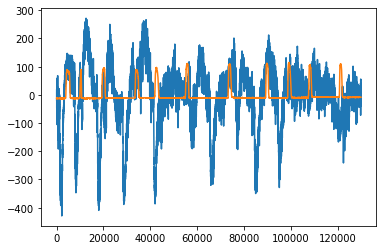

In [17]:
plt.plot(raw.get_data()[0,:])
plt.plot(raw.get_data()[-3,:]*20)

#### sharp wave detection: 
1. band filter data 5 - 90 Hz 
2. z-score data 
3. get troughs and peaks

In [39]:
filt = calc_band_filters(f_ranges=[[5, 90]], sample_rate=1000, filter_len=1001, l_trans_bandwidth=5, h_trans_bandwidth=5)

No data specified. Sanity checks related to the length of the signal relative to the filter order will be skipped.
Setting up band-pass filter from 5 - 90 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 2.50 Hz)
- Upper passband edge: 90.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 92.50 Hz)
- Filter length: 1001 samples (1.001 sec)



In [40]:
filt.shape

(1, 1001)

In [8]:
dat = raw.get_data()[:4,:]

In [29]:
dat.shape

(4, 130001)

In [10]:
dat_ = raw.get_data()[:1,:]
sample_rate = 1000
line_noise = 60

In [11]:
h = mne.filter.create_filter(None, sample_rate, l_freq=5, h_freq=90, 
                            fir_design='firwin', l_trans_bandwidth=5, 
                            h_trans_bandwidth=5, filter_length='1000ms')

No data specified. Sanity checks related to the length of the signal relative to the filter order will be skipped.
Setting up band-pass filter from 5 - 90 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 2.50 Hz)
- Upper passband edge: 90.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 92.50 Hz)
- Filter length: 1001 samples (1.001 sec)



In [13]:
filtered_dat = scipy.signal.convolve(dat_, np.expand_dims(h, axis=0), mode='same')

In [137]:
filtered_dat.shape

(1, 130001)

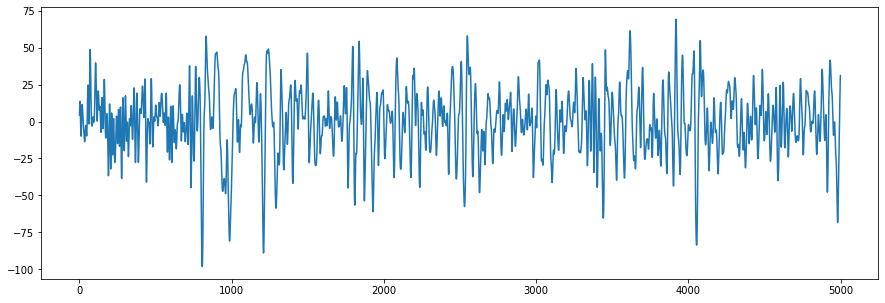

In [21]:
plt.figure(figsize=(15,5))
plt.plot(filtered_dat[0,:][10000:15000])

In [27]:
rel = filtered_dat[0,20000:25000]

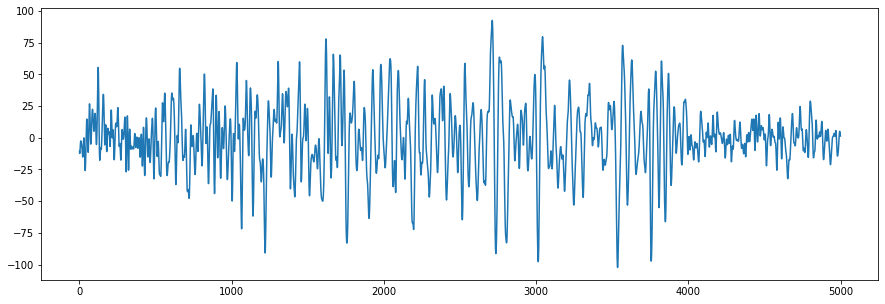

In [28]:
plt.figure(figsize=(15,5))
plt.plot(rel)

In [39]:
scipy.signal.find_peaks(rel)[0]

array([   9,   29,   48,   66,   85,  103,  122,  139,  157,  172,  186,
        194,  209,  220,  239,  252,  265,  280,  298,  314,  330,  342,
        351,  363,  377,  391,  406,  421,  439,  456,  479,  500,  517,
        529,  545,  560,  585,  607,  616,  642,  658,  685,  697,  713,
        732,  746,  771,  788,  821,  837,  876,  898,  917,  938,  957,
        991, 1012, 1033, 1050, 1076, 1097, 1123, 1154, 1168, 1204, 1241,
       1278, 1290, 1305, 1334, 1357, 1374, 1396, 1446, 1481, 1498, 1529,
       1551, 1573, 1619, 1642, 1668, 1688, 1713, 1738, 1778, 1804, 1835,
       1853, 1871, 1927, 1961, 1980, 2040, 2070, 2095, 2128, 2149, 2160,
       2189, 2221, 2235, 2250, 2267, 2317, 2335, 2376, 2394, 2435, 2469,
       2499, 2532, 2586, 2638, 2662, 2686, 2711, 2759, 2769, 2830, 2847,
       2878, 2901, 2932, 2959, 2992, 3042, 3056, 3087, 3097, 3121, 3161,
       3175, 3219, 3279, 3292, 3328, 3342, 3351, 3377, 3389, 3398, 3426,
       3447, 3476, 3487, 3512, 3568, 3628, 3689, 37

In [63]:
x = rel 
peaks = scipy.signal.find_peaks(x, distance=5)[0]
troughs = scipy.signal.find_peaks(-x, distance=1)[0]

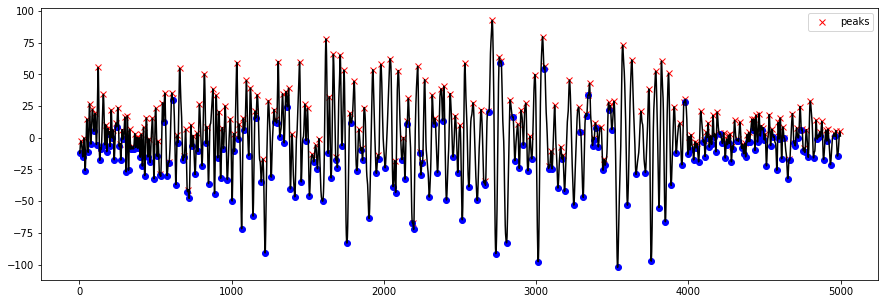

In [66]:
# alrighty, now try to find peaks 
plt.figure(figsize=(15,5))
plt.plot(peaks, x[peaks], "xr"); 
plt.plot(troughs, x[troughs], "ob"); 
plt.plot(x, color='black'); plt.legend(['peaks'])

In [112]:
def get_peaks_around(peak_ind, arr_ind_peaks, arr_peaks):

    ind_greater = np.where(arr_ind_peaks>peak_ind)[0]
    val_ind_greater = arr_ind_peaks[ind_greater]
    peak_right = arr_ind_peaks[ind_greater[np.argsort(val_ind_greater)[0]]]
    
    ind_smaller = np.where(arr_ind_peaks<peak_ind)[0]
    val_ind_smaller= arr_ind_peaks[ind_smaller]
    peak_left = arr_ind_peaks[ind_smaller[np.argsort(val_ind_smaller)[-1]]]
    
    return peak_left, peak_right, arr_peaks[peak_left], arr_peaks[peak_left]

In [149]:
x = filtered_dat[0,:]
y_contra = raw.get_data()[9,:]
y_ipsi = raw.get_data()[8,:]
peaks = scipy.signal.find_peaks(x, distance=5)[0]
troughs = scipy.signal.find_peaks(-x, distance=1)[0]

In [155]:
troughs.shape

(5330,)

In [209]:
# now, run through every trough and identify the "sharp" wave
# important, consecutive troughs should be closer than 5ms, might be more, not sure here 
# in a surrounding of 5 ms, was is the sharpness voltage difference of the trough 
df  = pd.DataFrame()
sharp_wave = {}
for _, trough in enumerate(troughs):
    print(trough)
    try:
        peak_idx_left, peak_idx_right, peak_left, peak_right = get_peaks_around(trough, peaks, x[peaks])
    except:
        # in this case there is no adjacent two peaks around this trough
        continue
    if df.shape[0]>0:
        interval_ = trough - sharp_wave["trough_idx"]
    else:
        interval_ = 0
    if y_contra[trough] > 0:
        MOV_ = "CON"
    elif y_ipsi[trough] > 0:
        MOV_ = "IPS"
    else:
        MOV_ = "NONE"
    sharp_wave  = {
        "peak_left":peak_left, 
        "peak_right":peak_right,
        "peak_idx_left" : peak_idx_left,
        "peak_idx_right" : peak_idx_right,
        "trough":x[trough],
        "trough_idx":trough,
        "width": peak_idx_right - peak_idx_left, 
        "prominence": np.abs((peak_right + peak_left) / 2 - trough),
        "interval" : interval_, 
        "decay_time": peak_idx_left - trough,
        "rise_time" : peak_idx_right - trough, 
        "MOV":MOV_
    }
    df = df.append(sharp_wave, ignore_index=True)
    

28
69
87
111
141
155
204
250
266
326
383
400
461
489
544
610
631
675
709
765
813
842
893
921
949
980
994
1034
1053
1071
1107
1141
1188
1209
1234
1273
1315
1333
1367
1423
1491
1532
1584
1643
1701
1723
1802
1828
1859
1890
1902
1926
1947
1976
2014
2042
2072
2080
2122
2178
2222
2240
2267
2313
2352
2368
2391
2432
2446
2502
2511
2542
2556
2574
2590
2619
2643
2672
2678
2714
2731
2760
2782
2803
2825
2857
2878
2903
2918
2941
2956
2974
2987
3011
3029
3057
3070
3095
3118
3132
3160
3181
3197
3220
3252
3270
3284
3295
3307
3321
3336
3357
3371
3394
3407
3427
3435
3450
3478
3501
3519
3549
3566
3577
3604
3613
3628
3642
3656
3669
3694
3704
3718
3733
3748
3773
3796
3812
3823
3834
3856
3872
3884
3922
3930
3948
3959
3971
3983
3997
4012
4028
4044
4056
4072
4087
4101
4115
4129
4143
4158
4173
4189
4203
4226
4239
4254
4265
4281
4298
4314
4330
4344
4359
4374
4397
4408
4425
4436
4450
4469
4489
4507
4516
4527
4541
4559
4578
4602
4620
4655
4668
4680
4695
4713
4728
4745
4766
4781
4805
4816
4835
4855
4872
4891
4908


46583
46592
46620
46628
46655
46678
46714
46731
46784
46825
46841
46880
46919
46943
46954
46977
47000
47006
47037
47058
47075
47107
47134
47158
47192
47215
47251
47263
47301
47314
47349
47369
47418
47443
47472
47489
47521
47564
47626
47691
47757
47775
47825
47875
47924
47954
47974
47988
48012
48030
48044
48067
48085
48098
48113
48142
48168
48209
48239
48280
48301
48319
48346
48367
48382
48403
48426
48437
48447
48481
48540
48578
48596
48619
48635
48664
48691
48704
48727
48747
48790
48822
48835
48873
48896
48911
48933
48960
48984
49021
49052
49085
49108
49131
49147
49177
49209
49238
49271
49328
49350
49367
49390
49405
49434
49484
49494
49543
49590
49645
49676
49709
49731
49755
49805
49822
49869
49891
49942
49947
49988
50040
50065
50112
50140
50178
50195
50218
50236
50253
50293
50309
50340
50369
50382
50400
50411
50426
50448
50459
50476
50494
50503
50518
50539
50554
50583
50603
50616
50629
50648
50659
50678
50693
50708
50740
50763
50776
50800
50812
50833
50885
50923
50953
50981
50993
5100

82504
82527
82576
82625
82699
82736
82765
82795
82807
82828
82841
82856
82883
82916
82934
82970
82986
83009
83034
83042
83072
83088
83119
83141
83158
83178
83215
83248
83290
83326
83378
83417
83477
83534
83567
83591
83602
83624
83651
83712
83725
83734
83763
83814
83829
83849
83862
83889
83909
83934
83963
83984
84006
84033
84082
84129
84167
84184
84198
84256
84311
84344
84393
84435
84450
84465
84474
84518
84551
84564
84577
84605
84641
84664
84690
84738
84780
84798
84817
84854
84918
84956
84978
85000
85036
85047
85082
85136
85160
85189
85240
85273
85296
85328
85340
85379
85414
85446
85471
85526
85561
85584
85644
85674
85700
85744
85783
85828
85873
85900
85935
85959
85985
86011
86024
86049
86073
86090
86108
86117
86151
86192
86208
86230
86251
86271
86290
86314
86347
86366
86390
86437
86447
86474
86496
86519
86547
86578
86635
86666
86684
86708
86726
86739
86751
86762
86777
86794
86824
86844
86880
86895
86902
86922
86944
86979
87004
87036
87086
87109
87124
87151
87158
87168
87190
87211
8723

125195
125208
125234
125258
125279
125299
125319
125339
125360
125373
125398
125430
125457
125471
125494
125507
125521
125544
125560
125582
125598
125611
125623
125637
125656
125675
125688
125716
125739
125784
125797
125814
125833
125848
125877
125889
125908
125921
125936
125948
125962
125978
125993
126009
126020
126055
126071
126088
126106
126148
126165
126177
126209
126261
126305
126318
126363
126411
126432
126458
126490
126552
126587
126612
126653
126679
126698
126708
126719
126736
126751
126803
126812
126851
126883
126906
126924
126937
126946
126958
126981
126996
127043
127089
127100
127127
127167
127190
127210
127239
127268
127280
127305
127329
127350
127378
127427
127471
127483
127506
127528
127577
127625
127655
127674
127704
127718
127730
127736
127785
127810
127833
127897
127930
127960
128016
128031
128065
128112
128164
128215
128254
128288
128338
128387
128435
128448
128458
128481
128538
128589
128600
128667
128698
128712
128757
128781
128788
128804
128824
128837
128844
128860

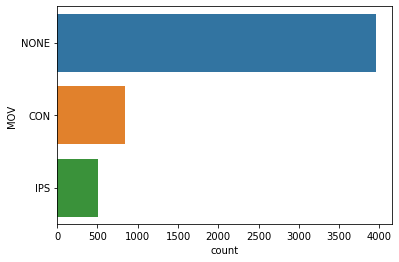

In [167]:
sn.countplot(y="MOV", data = df)

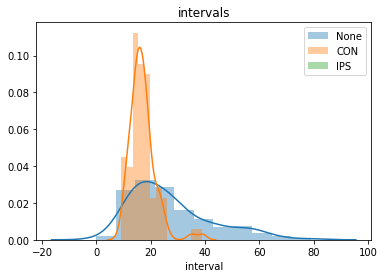

In [210]:
sn.distplot(df[df.MOV.str.contains("NONE")]["interval"], label='None')
sn.distplot(df[df.MOV.str.contains("CON")]["interval"], label='CON')
sn.distplot(df[df.MOV.str.contains("IPS")]["interval"], label='IPS')
plt.title('intervals')
plt.legend()

In [180]:
df.keys()

Index(['MOV', 'decay_time', 'interval', 'peak_idx_left', 'peak_idx_right',
       'peak_left', 'peak_right', 'prominence', 'rise_time', 'trough',
       'trough_idx', 'width'],
      dtype='object')

In [186]:
def plot_mov_sep_hist(metric):
    sn.distplot(df[df.MOV.str.contains("NONE")][metric], label='None')
    sn.distplot(df[df.MOV.str.contains("CON")][metric], label='CON')
    sn.distplot(df[df.MOV.str.contains("IPS")][metric], label='IPS')
    plt.title(metric)
    plt.legend()

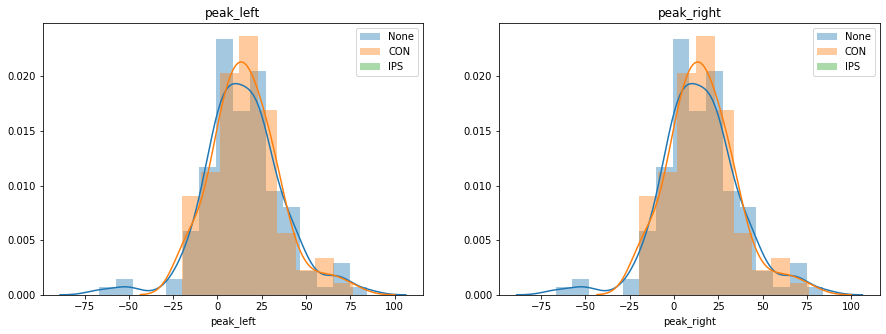

In [211]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plot_mov_sep_hist("peak_left")
plt.subplot(122)
plot_mov_sep_hist("peak_right")

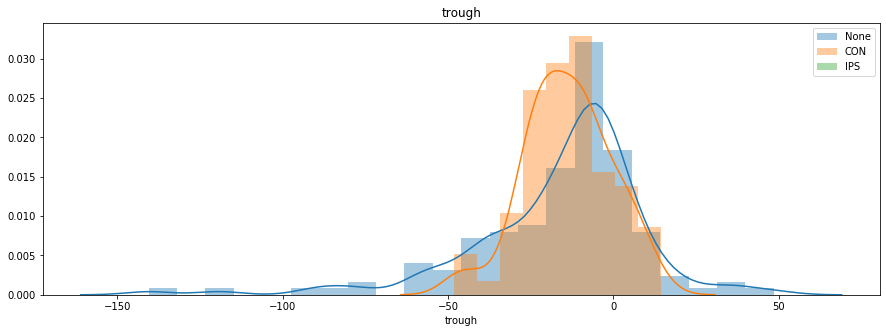

In [212]:
plt.figure(figsize=(15,5))
plot_mov_sep_hist("trough")

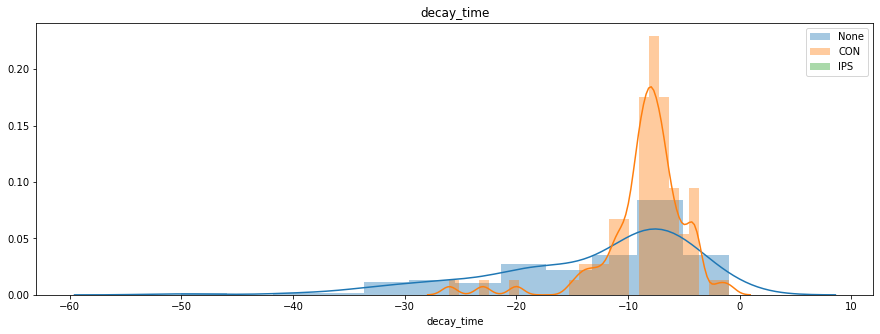

In [213]:
plt.figure(figsize=(15,5))
plot_mov_sep_hist("decay_time")

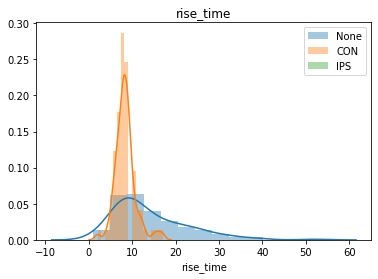

In [214]:
sn.distplot(df[df.MOV.str.contains("NONE")]["rise_time"], label='None')
sn.distplot(df[df.MOV.str.contains("CON")]["rise_time"], label='CON')
sn.distplot(df[df.MOV.str.contains("IPS")]["rise_time"], label='IPS')
plt.title('rise_time')
plt.legend()